In [30]:
%%capture
from pathlib import Path

if Path.cwd().stem == "models":
    %cd ../..
    %load_ext autoreload
    %autoreload 2

In [34]:
import logging
import operator
from functools import reduce
from pathlib import Path

import holoviews as hv
import hvplot.polars  # noqa
import matplotlib.pyplot as plt
import numpy as np
import optuna
import polars as pl
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from icecream import ic
from ipywidgets import interact
from polars import col
from polars.datatypes.group import FLOAT_DTYPES, INTEGER_DTYPES
from sklearn.metrics import auc, confusion_matrix, roc_curve
from sklearn.model_selection import GroupShuffleSplit
from torch.utils.data import DataLoader, TensorDataset

from src.data.database_manager import DatabaseManager
from src.features.labels import add_labels
from src.features.resampling import (
    add_normalized_timestamp,
    interpolate_and_fill_nulls,
    resample_at_10_hz_equidistant,
)
from src.features.scaling import scale_min_max, scale_robust_standard, scale_standard
from src.features.transforming import merge_dfs
from src.features.utils import to_describe
from src.log_config import configure_logging
from src.models.architectures import LongShortTermMemory, MultiLayerPerceptron
from src.models.data_loader import create_dataloaders, transform_sample_df_to_arrays
from src.models.sample_creation import create_samples, make_sample_set_balanced
from src.models.scalers import StandardScaler3D, scale_dataset
from src.models.utils import get_device, load_model, save_model, get_input_shape
from src.plots.utils import prepare_multiline_hvplot

configure_logging(
    stream_level=logging.DEBUG,
    ignore_libs=["matplotlib", "Comm", "bokeh", "tornado"],
)

pl.Config.set_tbl_rows(12)  # for the 12 trials
hv.output(widget_location="bottom", size=130)

device = get_device()

18:29:17 | INFO    | utils | Using device: mps


In [35]:
from src.models.models_optuna_tsl import initialize_model

logger = logging.getLogger(__name__.rsplit(".", 1)[-1])


In [36]:
model = load_model("models/PatchTST_20250310-174850.pt")

18:29:17 | INFO    | utils | Using device: mps
18:29:17 | INFO    | utils | Loaded PatchTST model (input_shape=(51, 3)) with test accuracy 0.79%


/Users/visser/Dropbox/PhD/Code/pain-measurement/src/models/utils.py:106: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  save_dict = torch.load(model_path)


In [38]:
RANDOM_SEED = 42
BATCH_SIZE = 64


def evaluate_saved_model(model_path, dataset_params=None):
    """
    Load a saved model and evaluate it on the test set to generate a confusion matrix.

    Args:
        model_path: Path to the saved model file
        dataset_params: Optional dictionary with custom dataset parameters.
                       If None, uses the same parameters as in training.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import torch
    from sklearn.metrics import (
        confusion_matrix,
        ConfusionMatrixDisplay,
        classification_report,
    )

    # Use default parameters if none provided
    if dataset_params is None:
        dataset_params = {
            "exclude_trials_with_measurement_problems": True,
            "intervals": {
                "decreases": "major_decreasing_intervals",
                "increases": "strictly_increasing_intervals_without_plateaus",
            },
            "label_mapping": {
                "decreases": 0,
                "increases": 1,
            },
            "sample_duration_ms": 5000,
            "feature_columns": [
                "eda_tonic",
                "eda_phasic",
                "pupil_mean",
            ],
        }

    # Load model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    save_dict = torch.load(model_path, map_location=device)
    model_name = save_dict["model_name"]
    hyperparams = save_dict["hyperparameters"]
    state_dict = save_dict["model_state_dict"]
    input_shape = save_dict["input_shape"]

    print(
        f"Loading model {model_name} with test accuracy: {save_dict['test_accuracy']}"
    )

    # Get data for evaluation
    db = DatabaseManager()
    with db:
        df = db.get_table(
            "Merged_and_Labeled_Data",
            exclude_trials_with_measurement_problems=dataset_params[
                "exclude_trials_with_measurement_problems"
            ],
        )

    # Create and prepare dataset
    samples = create_samples(
        df,
        dataset_params["intervals"],
        dataset_params["sample_duration_ms"],
        dataset_params["label_mapping"],
    )
    samples = make_sample_set_balanced(samples)
    samples = samples.select(
        "sample_id",
        "participant_id",
        "rating",
        "temperature",
        "eda_raw",
        "eda_tonic",
        "eda_phasic",
        "pupil_mean",
        "pupil_mean_tonic",
        "label",
    )

    X, y, groups = transform_sample_df_to_arrays(
        samples, feature_columns=dataset_params["feature_columns"]
    )

    # Split the data into training+validation set and test set
    splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_SEED)
    idx_train_val, idx_test = next(splitter.split(X, y, groups=groups))
    X_test, y_test = X[idx_test], y[idx_test]

    # Initialize model
    model, criterion, _, _ = initialize_model(
        model_name, input_shape, device, **hyperparams
    )

    # Load weights
    model.load_state_dict(state_dict)
    model.to(device)
    model.eval()

    # Create test dataloader
    _, test_loader = create_dataloaders(
        None, None, X_test, y_test, batch_size=BATCH_SIZE
    )

    # Evaluate model
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            y_true.extend(targets.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Display confusion matrix
    class_names = list(dataset_params["label_mapping"].keys())
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(10, 8))
    disp.plot(ax=ax)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.savefig(f"confusion_matrix_{model_name}.png")
    plt.show()

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    return {
        "confusion_matrix": cm,
        "classification_report": classification_report(
            y_true, y_pred, target_names=class_names, output_dict=True
        ),
        "y_true": y_true,
        "y_pred": y_pred,
    }


# Helper function to save model
def save_model(model, accuracy, best_params, model_name, X_sample):
    """Save model with all necessary information for later inference."""
    import os
    import torch

    # Create directory if it doesn't exist
    os.makedirs("models", exist_ok=True)

    # Create save dictionary with all necessary information
    save_dict = {
        "model_state_dict": model.state_dict(),
        "hyperparameters": best_params,
        "model_name": model_name,
        "test_accuracy": accuracy,
        "input_shape": get_input_shape(model_name, X_sample),
    }

    # Save the model
    torch.save(save_dict, f"models/{model_name}.pt")
    print(f"Model saved to models/{model_name}.pt")


# Usage example
if __name__ == "__main__":
    model_path = "models/PatchTST_20250310-174850.pt"  # Replace with your model path
    results = evaluate_saved_model(model_path)

/var/folders/54/0yy_ylvj7tx247wkq0n07dnr0000gn/T/ipykernel_36662/1829709086.py:45: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  save_dict = torch.load(model_path, map_locat

Loading model PatchTST with test accuracy: 0.7854785478547854


AttributeError: 'NoneType' object has no attribute 'shape'

In [21]:
torch.device("cuda")

device(type='cuda')

In [5]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from src.models.inception_time_pytorch.model import InceptionTime
from src.models.inception_time_pytorch.modules import InceptionModel
from src.models.inception_time_pytorch.plots import plot

# Generate the data
N = 60  # number of time series
C = 10  # number of dimensions of each time series
L = 100  # number of samples of each time series
# x = np.zeros((N, C, L))
x = np.zeros((N, L, C))
# t = np.linspace(0, 1, L)
t = np.linspace(0, 1, C)
c = np.cos(2 * np.pi * (10 * t - 0.5))
s = np.sin(2 * np.pi * (20 * t - 0.5))
x[: N // 3] = 20 + 20 * c + 5 * np.random.normal(size=(N // 3, L, C))
x[N // 3 : 2 * N // 3] = 20 + 20 * s + 5 * np.random.normal(size=(N // 3, L, C))
x[2 * N // 3 :] = 20 + 20 * c + 20 * s + 5 * np.random.normal(size=(N // 3, L, C))
y = np.concatenate([0 * np.ones(N // 3), 1 * np.ones(N // 3), 2 * np.ones(N // 3)])


# Scale the data.
mu = np.nanmean(x, axis=0, keepdims=True)
sigma = np.nanstd(x, axis=0, keepdims=True)
x = (x - mu) / sigma

# Save the data.
x = torch.from_numpy(x).float().to(device)
y = torch.from_numpy(y).long().to(device)

# custom data
# y = torch.from_numpy(y_.copy()).long().to(device)
# x = torch.from_numpy(X.transpose(0, 2, 1)).float().to(device)

# Split the data
# x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.3)


# # Generate the training dataset.
# dataset = torch.utils.data.DataLoader(
#     dataset=torch.utils.data.TensorDataset(x, y),
#     batch_size=32,
#     shuffle=True,
# )


# # Create the model
# model = InceptionModel(input_size=x.shape[1], num_classes=3, filters=32, depth=6).to(
#     device
# )

In [6]:
x.size()

torch.Size([60, 100, 10])

In [ ]:
Namespace = lambda x: x
configs: Namespace(
    task_name="classification",
    is_training=1,
    model_id="UWaveGestureLibrary",
    model="PatchTST",
    data="UEA",
    root_path="./dataset/UWaveGestureLibrary/",
    data_path="ETTh1.csv",
    features="M",
    target="OT",
    freq="h",
    checkpoints="./checkpoints/",
    seq_len=np.int64(315),
    label_len=48,
    pred_len=0,
    seasonal_patterns="Monthly",
    inverse=False,
    mask_rate=0.25,
    anomaly_ratio=0.25,
    expand=2,
    d_conv=4,
    top_k=3,
    num_kernels=6,
    enc_in=3,
    dec_in=7,
    c_out=7,
    d_model=128,
    n_heads=8,
    e_layers=3,
    d_layers=1,
    d_ff=256,
    moving_avg=25,
    factor=1,
    distil=True,
    dropout=0.1,
    embed="timeF",
    activation="gelu",
    channel_independence=1,
    decomp_method="moving_avg",
    use_norm=1,
    down_sampling_layers=0,
    down_sampling_window=1,
    down_sampling_method=None,
    seg_len=96,
    num_workers=10,
    itr=1,
    train_epochs=100,
    batch_size=16,
    patience=10,
    learning_rate=0.001,
    des="Exp",
    loss="MSE",
    lradj="type1",
    use_amp=False,
    use_gpu=True,
    gpu=0,
    gpu_type="cuda",
    use_multi_gpu=False,
    devices="0,1,2,3",
    p_hidden_dims=[128, 128],
    p_hidden_layers=2,
    use_dtw=False,
    augmentation_ratio=0,
    seed=2,
    jitter=False,
    scaling=False,
    permutation=False,
    randompermutation=False,
    magwarp=False,
    timewarp=False,
    windowslice=False,
    windowwarp=False,
    rotation=False,
    spawner=False,
    dtwwarp=False,
    shapedtwwarp=False,
    wdba=False,
    discdtw=False,
    discsdtw=False,
    extra_tag="",
    patch_len=16,
    device=device(type="mps"),
    num_class=8,
)

In [ ]:
import torch

from src.Time_Series_Library.layers.Embed import PatchEmbedding
from src.Time_Series_Library.layers.SelfAttention_Family import (
    AttentionLayer,
    FullAttention,
)
from src.Time_Series_Library.layers.Transformer_EncDec import Encoder, EncoderLayer


class Transpose(nn.Module):
    def __init__(self, *dims, contiguous=False):
        super().__init__()
        self.dims, self.contiguous = dims, contiguous

    def forward(self, x):
        if self.contiguous:
            return x.transpose(*self.dims).contiguous()
        else:
            return x.transpose(*self.dims)


class Model(nn.Module):
    """
    Paper link: https://arxiv.org/pdf/2211.14730.pdf
    """

    def __init__(
        self,
        num_class,  # number of classes, adapt to dataset
        seq_len=np.int64(315),
        patch_len=16,
        stride=8,
        d_model=128,  # dimension of embedding
        dropout=0.1,
        factor=1,
        activation="gelu",
        n_heads=8,
        d_ff=256,
        e_layers=3,
        enc_in=3,  #  encoder input size, the number of features for a piece of data
    ):
        """
        patch_len: int, patch len for patch_embedding
        stride: int, stride for patch_embedding
        """
        super().__init__()
        padding = stride

        # patching and embedding
        self.patch_embedding = PatchEmbedding(
            d_model, patch_len, stride, padding, dropout
        )

        # Encoder
        self.encoder = Encoder(
            [
                EncoderLayer(
                    AttentionLayer(
                        FullAttention(
                            False,
                            factor,
                            attention_dropout=dropout,
                            output_attention=False,
                        ),
                        d_model,
                        n_heads,
                    ),
                    d_model,
                    d_ff,
                    dropout=dropout,
                    activation=activation,
                )
                for _ in range(e_layers)
            ],
            norm_layer=nn.Sequential(
                Transpose(1, 2),
                nn.BatchNorm1d(d_model),
                Transpose(1, 2),
            ),
        )

        # Classification head
        self.head_nf = d_model * int((seq_len - patch_len) / stride + 2)
        self.flatten = nn.Flatten(start_dim=-2)
        self.dropout = nn.Dropout(dropout)
        self.projection = nn.Linear(self.head_nf * enc_in, num_class)

    def forward(self, x_enc, x_mark_enc):
        # Normalization from Non-stationary Transformer
        means = x_enc.mean(1, keepdim=True).detach()
        x_enc = x_enc - means
        stdev = torch.sqrt(torch.var(x_enc, dim=1, keepdim=True, unbiased=False) + 1e-5)
        x_enc /= stdev

        # do patching and embedding
        x_enc = x_enc.permute(0, 2, 1)
        # u: [bs * nvars x patch_num x d_model]
        enc_out, n_vars = self.patch_embedding(x_enc)

        # Encoder
        # z: [bs * nvars x patch_num x d_model]
        enc_out, attns = self.encoder(enc_out)
        # z: [bs x nvars x patch_num x d_model]
        enc_out = torch.reshape(
            enc_out, (-1, n_vars, enc_out.shape[-2], enc_out.shape[-1])
        )
        # z: [bs x nvars x d_model x patch_num]
        enc_out = enc_out.permute(0, 1, 3, 2)

        # Decoder
        output = self.flatten(enc_out)
        output = self.dropout(output)
        output = output.reshape(output.shape[0], -1)
        output = self.projection(output)  # (batch_size, num_classes)
        # output is dec_out: [B, N]
        return output


model = Model(3)

In [ ]:
# Generate the data
N = 60  # number of time series
C = 10  # number of dimensions of each time series
L = 100  # number of samples of each time series
# x = np.zeros((N, C, L))
x = np.zeros((N, L, C))
# t = np.linspace(0, 1, L)
t = np.linspace(0, 1, C)
c = np.cos(2 * np.pi * (10 * t - 0.5))
s = np.sin(2 * np.pi * (20 * t - 0.5))
x[: N // 3] = 20 + 20 * c + 5 * np.random.normal(size=(N // 3, L, C))
x[N // 3 : 2 * N // 3] = 20 + 20 * s + 5 * np.random.normal(size=(N // 3, L, C))
x[2 * N // 3 :] = 20 + 20 * c + 20 * s + 5 * np.random.normal(size=(N // 3, L, C))
y = np.concatenate([0 * np.ones(N // 3), 1 * np.ones(N // 3), 2 * np.ones(N // 3)])


# Scale the data.
mu = np.nanmean(x, axis=0, keepdims=True)
sigma = np.nanstd(x, axis=0, keepdims=True)
x = (x - mu) / sigma

# Save the data.
x = torch.from_numpy(x).float().to(device)
y = torch.from_numpy(y).long().to(device)

# custom data
# y = torch.from_numpy(y_.copy()).long().to(device)
# x = torch.from_numpy(X.transpose(0, 2, 1)).float().to(device)

# Split the data
# x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.3)


# Generate the training dataset.
dataset = torch.utils.data.DataLoader(
    dataset=torch.utils.data.TensorDataset(x, y),
    batch_size=32,
    shuffle=True,
)


# Create the model
model = InceptionModel(input_size=x.shape[1], num_classes=3, filters=32, depth=6).to(
    device
)

In [28]:
model = Model(3)

In [29]:
# Define the optimizer.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Define the loss function.
loss_fn = torch.nn.CrossEntropyLoss()

# Train the model.
print(f"Training model on {device}.")
model.train(True)
for epoch in range(20):
    for features, target in dataset:
        optimizer.zero_grad()
        output = model(features.to(device))
        loss = loss_fn(output, target.to(device))
        loss.backward()
        optimizer.step()
        accuracy = (
            torch.argmax(torch.nn.functional.softmax(output, dim=-1), dim=-1) == target
        ).float().sum() / target.shape[0]
        print(
            "epoch: {}, loss: {:,.6f}, accuracy: {:.6f}".format(
                1 + epoch, loss, accuracy
            )
        )
model.train(False)
print("-----------------------------------------")

Training model on mps.


TypeError: Model.forward() missing 1 required positional argument: 'x_mark_enc'

In [ ]:
import torch
import torch.fft
import torch.nn.functional as F
from layers.Conv_Blocks import Inception_Block_V1
from layers.Embed import DataEmbedding


def FFT_for_Period(x, k=2):
    # [B, T, C]
    xf = torch.fft.rfft(x, dim=1)
    # find period by amplitudes
    frequency_list = abs(xf).mean(0).mean(-1)
    frequency_list[0] = 0
    _, top_list = torch.topk(frequency_list, k)
    top_list = top_list.detach().cpu().numpy()
    period = x.shape[1] // top_list
    return period, abs(xf).mean(-1)[:, top_list]


class TimesBlock(nn.Module):
    def __init__(
        # TODO: NOTE random default values! compare with
        self,
        seq_len,
        d_model=512,
        d_ff=2048,
        num_kernels=32,
        top_k=2,
    ):
        super(TimesBlock, self).__init__()
        self.seq_len = seq_len
        self.k = top_k
        # parameter-efficient design
        self.conv = nn.Sequential(
            Inception_Block_V1(d_model, d_ff, num_kernels=num_kernels),
            nn.GELU(),
            Inception_Block_V1(d_ff, d_model, num_kernels=num_kernels),
        )

    def forward(self, x):
        B, T, N = x.size()
        period_list, period_weight = FFT_for_Period(x, self.k)

        res = []
        for i in range(self.k):
            period = period_list[i]
            # padding
            if (self.seq_len) % period != 0:
                length = (((self.seq_len) // period) + 1) * period
                padding = torch.zeros(
                    [x.shape[0], (length - (self.seq_len)), x.shape[2]]
                ).to(x.device)
                out = torch.cat([x, padding], dim=1)
            else:
                length = self.seq_len
                out = x
            # reshape
            out = (
                out.reshape(B, length // period, period, N)
                .permute(0, 3, 1, 2)
                .contiguous()
            )
            # 2D conv: from 1d Variation to 2d Variation
            out = self.conv(out)
            # reshape back
            out = out.permute(0, 2, 3, 1).reshape(B, -1, N)
            res.append(out[:, : (self.seq_len), :])
        res = torch.stack(res, dim=-1)
        # adaptive aggregation
        period_weight = F.softmax(period_weight, dim=1)
        period_weight = period_weight.unsqueeze(1).unsqueeze(1).repeat(1, T, N, 1)
        res = torch.sum(res * period_weight, -1)
        # residual connection
        res = res + x
        return res


class Model(nn.Module):
    """
    Paper link: https://openreview.net/pdf?id=ju_Uqw384Oq
    """

    def __init__(self, configs):
        super(Model, self).__init__()
        self.configs = configs
        self.seq_len = configs.seq_len
        self.label_len = configs.label_len
        self.model = nn.ModuleList(
            [TimesBlock(configs) for _ in range(configs.e_layers)]
        )
        self.enc_embedding = DataEmbedding(
            configs.enc_in,
            configs.d_model,
            configs.embed,
            configs.freq,
            configs.dropout,
        )
        self.layer = configs.e_layers
        self.layer_norm = nn.LayerNorm(configs.d_model)

        # Classification
        self.act = F.gelu
        self.dropout = nn.Dropout(configs.dropout)
        self.projection = nn.Linear(
            configs.d_model * configs.seq_len, configs.num_class
        )

    def classification(self, x_enc, x_mark_enc):
        # embedding
        enc_out = self.enc_embedding(x_enc, None)  # [B,T,C]
        # TimesNet
        for i in range(self.layer):
            enc_out = self.layer_norm(self.model[i](enc_out))

        # Output
        # the output transformer encoder/decoder embeddings don't include non-linearity
        output = self.act(enc_out)
        output = self.dropout(output)
        # zero-out padding embeddings
        output = output * x_mark_enc.unsqueeze(-1)
        # (batch_size, seq_length * d_model)
        output = output.reshape(output.shape[0], -1)
        output = self.projection(output)  # (batch_size, num_classes)
        return output

    def forward(self, x_enc, x_mark_enc, x_dec, x_mark_dec, mask=None):
        dec_out = self.classification(x_enc, x_mark_enc)
        return dec_out  # [B, N]


In [125]:
np.inf

inf

In [ ]:
a = dict(a=1, b=2, c=3)


ic(a)

ic| a: {'a': 1, 'b': 2, 'c': 3}


{'a': 1, 'b': 2, 'c': 3}

In [161]:
x = torch.randn(3, 2)
y = torch.transpose(x, 0, 1).contiguous()
x[0, :] = 42
print(y.contiguous()[0, 0])
x, y

tensor(-0.4004)


(tensor([[42.0000, 42.0000],
         [ 0.0539, -0.4846],
         [ 0.5358, -0.3474]]),
 tensor([[-0.4004,  0.0539,  0.5358],
         [ 0.7502, -0.4846, -0.3474]]))

In [41]:
db = DatabaseManager()

with db:
    df = db.get_table(
        "Merged_and_Labeled_Data",
        exclude_trials_with_measurement_problems=True,
    )
    trials = db.get_table("Trials", exclude_trials_with_measurement_problems=True)
df

trial_id,trial_number,participant_id,timestamp,temperature,rating,eda_raw,eda_tonic,eda_phasic,ppg_raw,ppg_ibi_shimmer,heartrate,pupil_l_raw,pupil_r_raw,pupil_r,pupil_l,pupil_mean,pupil_mean_tonic,brow_furrow,cheek_raise,mouth_open,upper_lip_raise,nose_wrinkle,normalized_timestamp,stimulus_seed,skin_patch,decreasing_intervals,major_decreasing_intervals,increasing_intervals,strictly_increasing_intervals,strictly_increasing_intervals_without_plateaus,plateau_intervals,prolonged_minima_intervals
u16,u8,u8,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,u16,u8,u16,u16,u16,u16,u16,u16,u16
1,1,1,294198.9762,0.0,0.425,0.743774,0.743503,0.000271,1408.404382,-1.062977,65.243881,5.670313,6.173421,5.641376,5.15944,5.400408,5.350094,0.00036,0.00286,0.0048,0.0,0.00007,0.0,396,1,0,0,1,0,0,0,0
1,1,1,294298.9762,0.000039,0.425,0.744641,0.743517,0.001124,1372.864366,-0.131651,65.242949,5.602895,6.142564,5.639922,5.157792,5.398857,5.343983,0.00036,0.00286,0.0048,0.0,0.00007,100.0,396,1,0,0,1,0,0,0,0
1,1,1,294398.9762,0.000154,0.395798,0.74488,0.743537,0.001343,1397.15563,-2.948082,65.241069,5.518026,6.072123,5.643301,5.160338,5.401819,5.337462,0.000341,0.002327,0.004199,0.0,0.000065,200.0,396,1,0,0,1,0,0,0,0
1,1,1,294498.9762,0.000417,0.270286,0.744808,0.743557,0.001252,1485.360361,1.488009,65.238629,5.399583,5.947853,5.638149,5.156922,5.397535,5.330919,0.000512,0.00122,0.002504,0.0,0.000065,300.0,396,1,0,0,1,0,0,0,0
1,1,1,294598.9762,0.000818,0.129521,0.74487,0.743578,0.001293,1496.64849,-4.735116,65.235505,5.276378,5.796069,5.646014,5.1618,5.403907,5.324177,0.001059,0.000701,0.002202,0.000006,0.000093,400.0,396,1,0,0,1,0,0,0,0
1,1,1,294698.9762,0.001358,0.152477,0.744957,0.743594,0.001363,1456.946658,1.28125,65.233139,5.158002,5.642459,5.62452,5.146081,5.3853,5.317484,0.001138,0.000565,0.001937,0.000017,0.00009,500.0,396,1,0,0,1,0,0,0,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
516,12,50,2.6956e6,0.031312,0.0,26.688608,26.716225,0.003169,1323.813266,-5.036073,59.279672,5.166699,4.766597,4.768156,5.167254,4.967705,5.180142,0.000465,0.001124,0.007081,0.00022,0.004168,179500.0,806,1,2580,1548,0,0,0,0,0
516,12,50,2.6957e6,0.030874,0.0,26.68499,26.716212,0.000389,1244.871959,44.337204,58.673362,5.026438,4.683481,4.690238,5.025632,4.857935,5.174284,0.000698,0.000846,0.007044,0.000348,0.004289,179600.0,806,1,2580,1548,0,0,0,0,0


In [13]:
# prepare_multiline_hvplot(
#     add_normalized_timestamp(df, "timestamp", "major_decreasing_intervals"),
#     "normalized_timestamp",
#     "major_decreasing_intervals",
# ).filter(col("major_decreasing_intervals") > 0).hvplot(
#     x="normalized_timestamp", y="temperature"
# )

In [42]:
intervals = {
    # "decreases": "decreasing_intervals",
    "decreases": "major_decreasing_intervals",
    "increases": "strictly_increasing_intervals_without_plateaus",
    # "plateaus": "plateau_intervals",
}
label_mapping = {
    "decreases": 0,
    "increases": 1,
    # "plateaus": 1,
}
sample_duration_ms = 5_000

samples = create_samples(df, intervals, sample_duration_ms, label_mapping)
samples = make_sample_set_balanced(
    samples
)  # TODO: improve balance function, maybe use f1 or mcc as metric instead of accuracy
samples = samples.select(
    "sample_id",
    "participant_id",
    "timestamp",
    "temperature",
    "eda_raw",
    "eda_tonic",
    "eda_phasic",
    "pupil_mean",
    "pupil_mean_tonic",
    "label",
)
print(samples["label"].value_counts())
samples


shape: (2, 2)
┌───────┬───────┐
│ label ┆ count │
│ ---   ┆ ---   │
│ u8    ┆ u32   │
╞═══════╪═══════╡
│ 0     ┆ 72063 │
│ 1     ┆ 72063 │
└───────┴───────┘


sample_id,participant_id,timestamp,temperature,eda_raw,eda_tonic,eda_phasic,pupil_mean,pupil_mean_tonic,label
u16,u8,f64,f64,f64,f64,f64,f64,f64,u8
1,1,363198.9762,0.967948,0.744613,0.744586,0.000027,4.658733,4.709513,0
1,1,363298.9762,0.967909,0.744724,0.744573,0.000151,4.659884,4.688126,0
1,1,363398.9762,0.967773,0.74465,0.74456,0.00009,4.658591,4.666663,0
1,1,363498.9762,0.967524,0.744585,0.744545,0.00004,4.637682,4.645174,0
1,1,363598.9762,0.967158,0.74454,0.744529,0.000011,4.581029,4.62372,0
1,1,363698.9762,0.966678,0.744388,0.744515,-0.000127,4.556353,4.602361,0
…,…,…,…,…,…,…,…,…,…
3096,50,2.6176e6,0.566078,28.028736,27.657549,0.371187,5.555003,5.493403,1
3096,50,2.6177e6,0.581691,28.044775,27.66556,0.379215,5.563552,5.496715,1


In [44]:
X, y, groups = transform_sample_df_to_arrays(
    samples,
    feature_columns=[
        # "temperature",  # only for visualization
        # "rating"
        "eda_raw",
        "eda_tonic",
        "pupil_mean",
    ],
)
print(f"{X.shape=}, {y.shape=}, {groups.shape=}")


@interact(trial=(0, X.shape[0] - 1))
def plot_trial(trial):
    for i in range(X.shape[2]):
        plt.plot(X[trial, :, i])
    # plt.ylim(0, 1.05)

X.shape=(2826, 51, 3), y.shape=(2826, 2), groups.shape=(2826,)


interactive(children=(IntSlider(value=1412, description='trial', max=2825), Output()), _dom_classes=('widget-i…

In [45]:
# Create a single train-test split while respecting group structure in the data
splitter = GroupShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
# might not be exactly 50% due to group structure
train_idx, test_idx = next(splitter.split(X, y, groups=groups))
assert set(groups[train_idx]).isdisjoint(set(groups[test_idx])), "Overlap in groups"
X_train, y_train = X[train_idx], y[train_idx]
X_test, y_test = X[test_idx], y[test_idx]


X_train, X_test = scale_dataset(X_train, X_test)


@interact(trial=(0, X_train.shape[0] - 1))
def plot_trial(trial):
    for i in range(X.shape[2]):
        plt.plot(X_train[trial, :, i])
    # plt.ylim(0, 1.05)

interactive(children=(IntSlider(value=698, description='trial', max=1397), Output()), _dom_classes=('widget-in…

In [46]:
batch_size = 64

train_loader, test_loader = create_dataloaders(
    X_train,
    y_train,
    X_test,
    y_test,
    batch_size=batch_size,
    is_test=True,
)

18:34:22 | DEBUG   | data_loader | Dataset summary: Train: 1398 samples, Test: 1428 samples | Input shape: (1398, 51, 3), Label shape: (1398, 2)


In [48]:
next(iter(train_loader))[0].numpy().shape

(64, 51, 3)

In [49]:
MODELS = {
    "MLP": {
        "class": MultiLayerPerceptron,
        "format": "2D",
        "hyperparameters": {
            "hidden_size": {"type": "int", "low": 128, "high": 4096},
            "lr": {"type": "float", "low": 1e-5, "high": 1e-1, "log": True},
        },
    },
    # Define other models with their respective hyperparameters and input sizes
    # "LSTM": {
    #     "class": LongShortTermMemory,
    #     "format": "3D",
    #     "hyperparameters": {
    #         "hidden_size": {"type": "int", "low": 128, "high": 1024},
    #         "num_layers": {"type": "int", "low": 1, "high": 2},
    #         "lr": {"type": "float", "low": 1e-5, "high": 1e-1, "log": True},
    #     },
    # },
    # "InceptionTime": {
    #     "class": Inception,
    #     "format": "3D",
    #     "hyperparameters": {
    #         "n_filters": {"type": "int", "low": 32, "high": 256},
}


def get_input_size(
    model_name: str,
    X: np.ndarray | DataLoader,
):
    data_format = MODELS[model_name]["format"]
    if isinstance(X, DataLoader):
        X = next(iter(X))[0].numpy()
    match data_format:
        case "2D":
            return X.shape[2] * X.shape[1]
        case "3D":
            return X.shape[2]
        case _:
            raise ValueError(f"Unknown data format: {data_format}")


In [50]:
def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    test_loader: DataLoader,
    criterion: nn.modules.loss._Loss,
    optimizer: optim.Optimizer,
    epochs: int,
    is_test: bool = True,
) -> dict[str, list[float]]:
    dataset = "test" if is_test else "validation"
    history = {
        "train_accuracy": [],
        "train_loss": [],
        f"{dataset}_accuracy": [],
        f"{dataset}_loss": [],
    }

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        # for acc metric only
        correct = 0
        total = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * X_batch.size(0)

            # Calculate training accuracy
            y_pred_classes = (torch.sigmoid(outputs) >= 0.5).float()
            total += y_batch.size(0)
            correct += (y_pred_classes == y_batch).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total if total > 0 else 0
        test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)

        # Store the metrics in the history dictionary
        history["train_loss"].append(epoch_loss)
        history["train_accuracy"].append(epoch_acc)
        history[f"{dataset}_loss"].append(test_loss)
        history[f"{dataset}_accuracy"].append(test_accuracy)

        # Log progress
        max_digits = len(str(epochs))
        logging.debug(
            f"E[{+epoch + 1:>{max_digits}d}/{epochs}] "
            f"| train {epoch_loss:.4f} ({epoch_acc:.1%}) "
            f"· {dataset} {test_loss:.4f} ({test_accuracy:.1%})"
        )

    return history


def evaluate_model(
    model: nn.Module,
    test_loader: DataLoader,
    criterion: nn.modules.loss._Loss,
) -> tuple[float, float]:
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.inference_mode():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred_logits = model(X_batch)
            loss = criterion(y_pred_logits, y_batch)
            total_loss += loss.item() * X_batch.size(0)
            # Metric here is acc
            y_pred_classes = (torch.sigmoid(y_pred_logits) >= 0.5).float()
            total += y_batch.size(0)
            correct += (y_pred_classes == y_batch).sum().item()

    average_loss = total_loss / total if total > 0 else 0
    accuracy = correct / total if total > 0 else 0
    return average_loss, accuracy


In [51]:
model = LongShortTermMemory(
    input_size=X_train.shape[1], hidden_size=256, num_layers=1
).to(device)

In [52]:
X_train.shape[2]

3

In [53]:
lr = 1e-3
epochs = 20
model = MultiLayerPerceptron(
    input_size=X.shape[2] * X.shape[1],  # 2D input length
    hidden_size=2048,
).to(device)

# Create the model
model = InceptionModel(input_size=x.shape[1], num_classes=2, filters=32, depth=6)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)


history = train_model(
    model,
    train_loader,
    test_loader,
    criterion,
    optimizer,
    epochs=epochs,
)

RuntimeError: Given groups=1, weight of size [32, 10, 1], expected input[64, 51, 3] to have 10 channels, but got 51 channels instead

In [56]:
model(torch.from_numpy(X_train[0]).unsqueeze(0).to(device))

RuntimeError: Given groups=1, weight of size [32, 10, 1], expected input[1, 51, 3] to have 10 channels, but got 51 channels instead

18:23:45 | DEBUG   | root | E[20/20] | train 0.6073 (68.1%) · test 0.6094 (67.7%)


In [ ]:
def plot_single_model_history(history):
    plt.figure(figsize=(15, 3))

    plt.subplot(1, 3, 1)
    plt.plot(history["train_loss"], label="Training Loss")
    plt.plot(history["test_loss"], label="Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(history["train_accuracy"], label="Training Accuracy")
    plt.plot(history["test_accuracy"], label="Test Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()


plot_single_model_history(history)

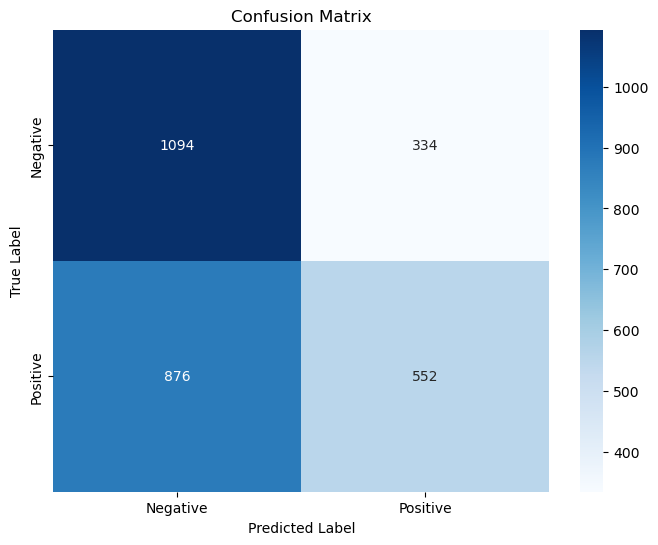

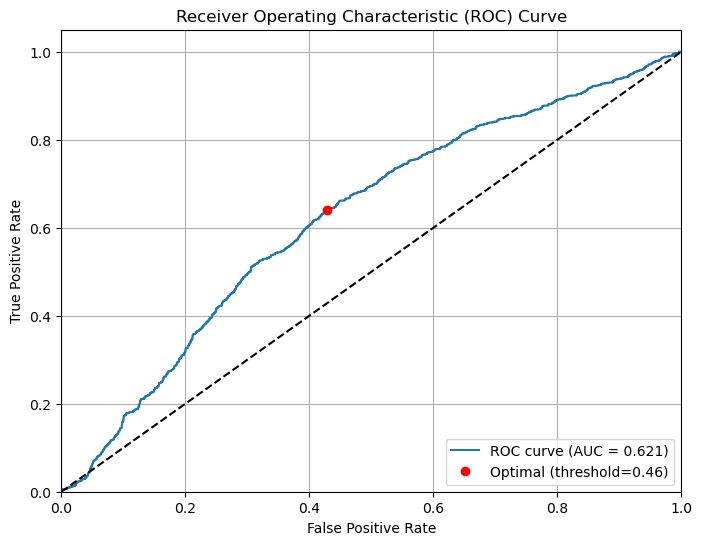

In [51]:
def get_confusion_matrix(
    model: nn.Module,
    test_loader: DataLoader,
    threshold: float = 0.5,
) -> np.ndarray:
    """
    Calculate confusion matrix for binary classification.
    Returns a 2x2 numpy array where:
    [0,0] = TN, [0,1] = FP
    [1,0] = FN, [1,1] = TP
    """
    model.eval()
    y_true = []
    y_pred = []

    with torch.inference_mode():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            # y_pred_batch = (torch.sigmoid(outputs) >= threshold).cpu().numpy()
            # Convert sigmoid outputs to binary predictions (0 or 1)
            y_pred_batch = (outputs.squeeze() >= threshold).int().cpu().numpy()
            # Ensure y_batch is also converted to numpy and has the right format
            y_batch = y_batch.int().cpu().numpy()

            y_true.extend(y_batch)
            y_pred.extend(y_pred_batch)

    # Convert lists to numpy arrays and ensure they're 1D
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()

    return confusion_matrix(y_true, y_pred)


def plot_confusion_matrix(conf_matrix: np.ndarray) -> None:
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        conf_matrix,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Negative", "Positive"],
        yticklabels=["Negative", "Positive"],
    )
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()


def plot_roc_curve(
    model: nn.Module,
    test_loader: DataLoader,
) -> None:
    """
    Plot ROC curve and calculate AUC score for binary classification.
    """
    model.eval()
    y_true = []
    y_scores = []

    with torch.inference_mode():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            # Get raw probabilities and convert to CPU numpy
            y_scores_batch = torch.sigmoid(outputs).squeeze().cpu().numpy()
            # Convert labels to numpy and ensure proper format
            y_batch = y_batch.int().cpu().numpy()

            y_true.extend(y_batch)
            y_scores.extend(y_scores_batch)

    # Convert lists to numpy arrays and ensure they're 1D
    y_true = np.array(y_true).flatten()
    y_scores = np.array(y_scores).flatten()

    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    auc_score = auc(fpr, tpr)

    # Find optimal threshold
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc_score:.3f})")
    plt.plot([0, 1], [0, 1], "k--")  # diagonal line

    # Add marker for optimal threshold
    plt.plot(
        fpr[optimal_idx],
        tpr[optimal_idx],
        "ro",
        label=f"Optimal (threshold={optimal_threshold:.2f})",
    )

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


conf_matrix = get_confusion_matrix(model, test_loader, threshold=0.5)
plot_confusion_matrix(conf_matrix)
plot_roc_curve(model, test_loader)

In [ ]:
# from dataclasses import dataclass


# @dataclass
# class TimesNetConfig:
#     task_name: str = "classification"
#     is_training: int = 1
#     model_id: str = "Heartbeat"
#     model: str = "TimesNet"
#     data: str = "UEA"
#     e_layers: int = 3
#     batch_size: int = 16
#     d_model: int = 16
#     d_ff: int = 32
#     top_k: int = 1
#     des: str = "Exp"
#     itr: int = 1
#     learning_rate: float = 0.001
#     train_epochs: int = 30
#     patience: int = 10
#     seq_len: int = 50
#     label_len: int = 1
#     pred_len: int = 1
#     num_kernels: int = 32
#     enc_in: int = 1
#     embed: int = 8
#     freq: str = "H"
#     dropout: float = 0.1
#     num_class: int = 2

#     def to_args_list(self) -> list:
#         """Convert config to command line arguments list"""
#         args = []
#         for key, value in self.__dict__.items():
#             args.extend([f"--{key}", str(value)])
#         return args


# # Example usage:
# configs = TimesNetConfig()
# configs

# from time_series_library.models import TimesNet

# model = TimesNet.Model(configs)


In [ ]:
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
from sktime.dists_kernels import FlatDist, ScipyDist

eucl_dist = FlatDist(ScipyDist())
clf = KNeighborsTimeSeriesClassifier(n_neighbors=3, distance=eucl_dist)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

In [ ]:
type(clf)

In [ ]:
isinstance(model, torch.nn.Module)

In [ ]:
import sktime

sktime.classification.distance_based._time_series_neighbors.KNeighborsTimeSeriesClassifier.__mro__

In [ ]:
from sktime.transformations.panel.rocket import MiniRocketMultivariate

minirocket_multi = MiniRocketMultivariate()
# minirocket_multi.fit(X_train)


In [ ]:
X_train.shape

In [ ]:
Path.cwd()

In [ ]:
import src.models.inception_time_pytorch.model

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score

# Generate the data
N = 60  # number of time series
C = 10  # number of dimensions of each time series
L = 100  # number of samples of each time series
x = np.zeros((N, C, L))
t = np.linspace(0, 1, L)
c = np.cos(2 * np.pi * (10 * t - 0.5))
s = np.sin(2 * np.pi * (20 * t - 0.5))
x[: N // 3] = 20 + 20 * c + 5 * np.random.normal(size=(N // 3, C, L))
x[N // 3 : 2 * N // 3] = 20 + 20 * s + 5 * np.random.normal(size=(N // 3, C, L))
x[2 * N // 3 :] = 20 + 20 * c + 20 * s + 5 * np.random.normal(size=(N // 3, C, L))
y = np.concatenate([0 * np.ones(N // 3), 1 * np.ones(N // 3), 2 * np.ones(N // 3)])

# Split the data
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.3)

# Fit the model
model = InceptionTime(
    x=x_train,
    y=y_train,
    filters=32,
    depth=6,
    models=2,
)

model.fit(
    learning_rate=0.001,
    batch_size=64,
    epochs=50,
    verbose=True,
)

# Evaluate the model
yhat_train = model.predict(x_train)
yhat_test = model.predict(x_test)
print("Training accuracy: {:.6f}".format(accuracy_score(y_train, yhat_train)))
print("Test accuracy: {:.6f}".format(accuracy_score(y_test, yhat_test)))

# Plot the results
fig = plot(x=x_test, y=yhat_test)
fig.write_image("results.png", scale=4, height=900, width=700)